In [ ]:
%cd ..

# Prepare USPTO-full for single-step retrosynthesis

In [2]:
# load the dataset

import pandas as pd
dfs = []
for split in ['train','val','test']:
    # The directory contains processed USPTO-full datasets from Dai by Tetko
    # Tetko, I. V.; Karpov, P.; Van Deursen, R.; Godin, G. 
    # Augmented Transformer for Direct and Single-Step Retrosynthesis Predictions Overperforms All Published Approaches.
    # Tatko removed - reactions which contained no products or just single ions as reactants and
    #               - reactions where reactants had less than five atoms in total
    df = pd.read_csv(f'https://github.com/bigchem/synthesis/raw/master/uspto-full/uspto_{split}T.csv.xz',sep=',')
    df['split'] = split if split!='val' else 'valid'
    dfs.append(df)
df = pd.concat(dfs)

In [3]:
import hashlib
def create_hash(pd_row):
    return hashlib.md5(pd_row.to_json().encode()).hexdigest()

if '_id' not in df.columns:
    df['_id'] = df.apply(create_hash, axis=1)

In [4]:
df['reaction_smiles'] = df['target']+'>>'+df['input']

In [5]:
reactants, spectators, products = list(zip(*[s.split('>') for s in df['reaction_smiles']]))
df['reactants'] = reactants
df['spectators'] = spectators
df['products'] = products

In [6]:
df['ctr'] = range(len(df))

In [11]:
#from rdchiral.template_extractor import extract_from_reaction
from mhnreact.molutils import extract_from_reaction

def extract_from_reaction_tc(r):
    try:
        #print(r['ctr'],end='\r')
        if r['ctr']==948614: #this sample takes forever
            return {'reaction_smarts':'','reaction_id':r['reaction_id']}
        re = extract_from_reaction(r,radius=1)
        if 'reaction_smarts' not in re:
            re['reaction_smarts'] = ''
        return re
    except:
        return {}

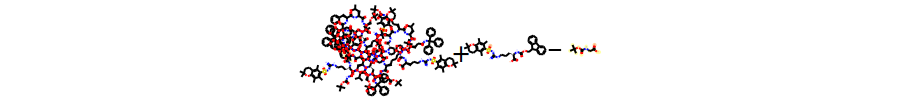

In [9]:
from mhnreact.inspect import smarts2svg
smarts2svg(df.iloc[948614]['reaction_smiles']);

In [10]:
extract_from_reaction_tc(df.iloc[0].to_dict())

{'products': '[#7;a:2]:[c;H0;D3;+0:1](:[c:3])-[c;H0;D3;+0:4](:[c:5]):[c:6]',
 'reactants': 'Br-[c;H0;D3;+0:1](:[#7;a:2]):[c:3].O-B(-O)-[c;H0;D3;+0:4](:[c:5]):[c:6]',
 'reaction_smarts': '[#7;a:2]:[c;H0;D3;+0:1](:[c:3])-[c;H0;D3;+0:4](:[c:5]):[c:6]>>Br-[c;H0;D3;+0:1](:[#7;a:2]):[c:3].O-B(-O)-[c;H0;D3;+0:4](:[c:5]):[c:6]',
 'intra_only': False,
 'dimer_only': False,
 'reaction_id': '56444038521f42b6a919b48bf0c01515',
 'necessary_reagent': '',
 'num_errors': 0,
 'num_warnings': 0}

import multiprocessing

reaction_dicts = [row.to_dict() for i, row in df.iterrows()]
with Pool(70) as pool:
    res = pool.map(extract_from_reaction_tc, reaction_dicts) # not even finished after 4 days :S

In [12]:
from tqdm.contrib.concurrent import process_map

import os
reaction_dicts = [row.to_dict() for i, row in df.iterrows()]
njobs = 70 #os.cpu_count()
res = process_map(extract_from_reaction_tc, reaction_dicts, max_workers=njobs, chunksize=1)

KeyboardInterrupt: 

In [46]:
df_res = pd.DataFrame.from_dict(res)

In [129]:
#assert list(df._id) == [r['reaction_id'] for r in res]
reaction_smarts = [r.get('reaction_smarts','') for r in res]
df['reaction_smarts'] = reaction_smarts

In [130]:
# canonicalize reactant (optionally product_can_from_reaction)
from mhnreact.retroeval import canonicalize_reactants
df['reactants_can'] = [canonicalize_reactants(r, can_steps=2) for r in df['reactants']]

In [131]:
def filter_by_dict(df, fil):
    for col, value in fil.items():
        if not isinstance(value, list):
            value = [value]
        df = df[df[col].isin(value)]
    return df

In [132]:
import re

mre = ':\d+(?=])'
unmapped = [re.sub(mre,'',r) for r in df['reaction_smarts']]
df['unmapped_template'] = unmapped

unmapped2idx = {}
labels = []
for split in ['train', 'valid', 'test']:
    sub = filter_by_dict(df, {'split': split})
    for u in sub['unmapped_template']:
        if u not in unmapped2idx:
            label = len(unmapped2idx)
            unmapped2idx[u] = label
            
df['label'] = [unmapped2idx[u] for u in df['unmapped_template']]

In [148]:
df['prod_smiles'] = [canonicalize_reactants(r, can_steps=2) for r in df['products']]

In [140]:
def valid_smarts(k:str):
    try:
        rxn = AllChem.ReactionFromSmarts(k)
        if rxn is None: return False
        nw,ne = rxn.Validate()
        if ne:
            return False
        return True
    except:
        return False
df['valid_reaction_smarts'] = df['reaction_smarts'].apply(valid_smarts)

In [149]:
# remove those from train and valid that are not valid smarts
df_woiv = df[(df.split=='test') | (df.valid_reaction_smarts)]

In [ ]:
# all the relevant data is now in here
df_rel = df[['prod_smiles','reactants_can','split', 'reaction_smarts', 'label']] #reaction_smiles is not saved -- saves around 50Mb

In [ ]:
df_rel.to_csv('./data/USPTO_full_MHN_prepro.csv.gz', index=False)

In [150]:
len(df), len(df_woiv)

(960927, 952543)

In [151]:
df_woiv[['prod_smiles','reactants_can','split', 'reaction_smarts', 'label']].to_csv('./data/USPTO_full_MHN_prepro_woiv.csv.gz', index=False)

In [16]:
#df.to_csv('./data/USPTO_50k_MHN_prepro_allcol.csv') # all columns